In [1]:
## 必要ライブラリのインポート
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optimizers
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# バージョンとディレクトリ位置の確認
print(torch.__version__) 
print(torchvision.__version__) 
!pwd

1.8.2+cu102
0.9.2+cu102
/home/ubuntu/AIC_GANlecture/lesson1_AE&VAE


In [3]:
np.random.seed(1234)
torch.manual_seed(1234)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# データの取得
root = os.path.join('data', 'mnist')
transform = transforms.Compose([transforms.ToTensor(),
                                lambda x: x.view(-1)])
mnist_train = torchvision.datasets.MNIST(root=root,
                                      download=True,
                                      train=True,
                                      transform=transform)
mnist_test = torchvision.datasets.MNIST(root=root,
                                      download=True,
                                      train=False,
                                      transform=transform)
train_dataloader = DataLoader(mnist_train,
                              batch_size=100,
                              shuffle=True)
test_dataloader = DataLoader(mnist_test,
                              batch_size=1,
                              shuffle=False)

In [4]:
class Autoencoder(nn.Module):
    def __init__(self, im, device='cpu'):
        super().__init__()
        self.device = device
        self.l1 = nn.Linear(784, 256)
        self.l2 = nn.Linear(256, im) # imは潜在空間の次元数
        self.l3 = nn.Linear(im, 256)
        self.l4 = nn.Linear(256, 784)

    def forward(self, x):
        # エンコーダ1層目
        h = self.l1(x)
        # 活性化関数
        h = torch.relu(h)
        # エンコーダ2層目
        h = self.l2(h)
        # 活性化関数
        h = torch.relu(h)

        # デコーダ1層目
        h = self.l3(h)
        # 活性化関数
        h = torch.relu(h)
        # デコーダ2層目
        h = self.l4(h)
        # シグモイド関数で0～1の値域に変換   
        y = torch.sigmoid(h)

        return y

In [5]:
# 潜在空間の次元数
im = 2
# モデルの設定
model = Autoencoder(im=im, device=device).to(device)
# 損失関数の設定
criterion = nn.BCELoss()
# 最適化関数の設定
optimizer = optimizers.Adam(model.parameters())

In [6]:
epochs = 10
loss_check = []
# エポックのループ
for epoch in range(epochs):
    train_loss = 0.
    # バッチサイズのループ
    for (x, _) in train_dataloader:
        x = x.to(device)
        # 訓練モードへの切替
        model.train()
        # 順伝播計算
        preds = model(x)
        # 入力画像xと復元画像predsの誤差計算
        loss = criterion(preds, x)
        # 勾配の初期化
        optimizer.zero_grad()
        # 誤差の勾配計算
        loss.backward()
        # パラメータの更新
        optimizer.step()
        # 訓練誤差の更新
        train_loss += loss.item()
        loss_check.append(loss.item())

    train_loss /= len(train_dataloader)

    print('Epoch: {}, Loss: {:.3f}'.format(
        epoch+1,
        train_loss
    ))

Epoch: 1, Loss: 0.259
Epoch: 2, Loss: 0.216
Epoch: 3, Loss: 0.205
Epoch: 4, Loss: 0.200
Epoch: 5, Loss: 0.196
Epoch: 6, Loss: 0.194
Epoch: 7, Loss: 0.192
Epoch: 8, Loss: 0.191
Epoch: 9, Loss: 0.190
Epoch: 10, Loss: 0.189


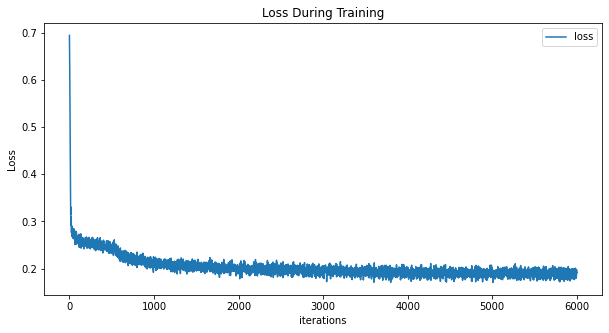

In [7]:
# 損失をプロット
plt.figure(figsize=(10,5))
plt.title("Loss During Training")
plt.plot(loss_check, label="loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

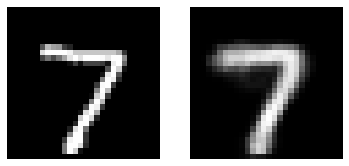

In [8]:
# dataloaderからのデータ取り出し
#print(iter(test_dataloader))
#print(test_dataloader)
x, _ = next(iter(test_dataloader))
x = x.to(device)

# 評価モードへの切替
model.eval()
# 復元画像
x_rec = model(x)

# 入力画像、復元画像の表示
for i, image in enumerate([x, x_rec]):
    image = image.view(28, 28).detach().cpu().numpy()
    plt.subplot(1, 2, i+1)
    plt.imshow(image, cmap='binary_r')
    plt.axis('off')
plt.show()

torch.Size([8, 28, 28])
(8, 28, 28)


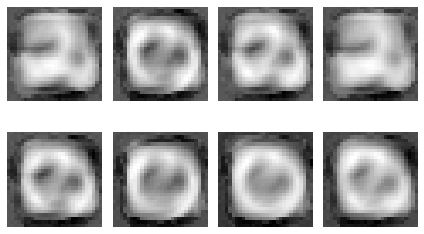

In [9]:
# ノイズの作成数
batch_size=8
# デコーダ入力用に標準正規分布に従う2次元のノイズを作成
z = torch.randn(batch_size, 2, device = device)

# デコーダにノイズzを入力
h = model.l3(z)# デコーダ
h = torch.relu(h)
images = model.l4(h)
images = images.view(-1, 28, 28)
print(images.shape)
images = images.squeeze().detach().cpu().numpy()
print(images.shape)

for i, image in enumerate(images):
    plt.subplot(2, 4, i+1)
    plt.imshow(image, cmap='binary_r')
    plt.axis('off')
plt.tight_layout()
plt.show()

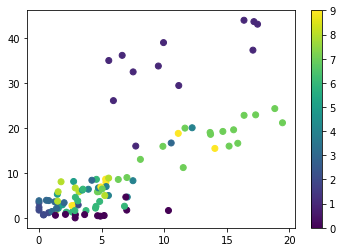

<Figure size 432x432 with 0 Axes>

In [10]:
# display a 2D plot of the digit classes in the latent space
i = 0
x, y = next(iter(train_dataloader))
x = x.to(device)
h = model.l1(x)
h = torch.relu(h)
h = model.l2(h)
h = torch.relu(h).detach().cpu().numpy()
#print(type(x), x.size(), x)
#print(type(y), y.size(), y[i])
#print(type(h), len(h), h)
sca = plt.scatter(h[:, 0], h[:, 1], c=y, cmap='viridis')
plt.colorbar(sca)
fig = plt.figure(figsize=(6, 6))

#プロットされた訓練データの周囲の点から似たような画像が生成される根拠がない
#画像の種類ごとに分布の範囲が異なり、生成される画像が異なる
#潜在空間の範囲が制限されず、疎な空間が存在する

In [11]:
test_dataloader = DataLoader(mnist_test,
                              batch_size=100,
                              shuffle=False)

In [12]:
class VAE(nn.Module):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self.encoder = Encoder(device=device)
        self.decoder = Decoder(device=device)

    def forward(self, x):
        # エンコーダ
        mean, var = self.encoder(x)
        # 潜在変数の作成
        z = self.reparameterize(mean, var)
        # デコーダ
        y = self.decoder(z)
        #生成画像yと潜在変数zが返り値
        return y, z

    # 潜在変数zの作成
    def reparameterize(self, mean, var):
        # 標準正規分布の作成
        eps = torch.randn(mean.size()).to(self.device)
        # 再パラメータ化トリック
        z = mean + torch.sqrt(var) * eps
        return z

    # 誤差の計算
    def lower_bound(self, x):
        # 平均と分散のベクトルを計算
        mean, var = self.encoder(x)
        # 平均と分散から潜在変数zを作成
        z = self.reparameterize(mean, var)
        # 潜在変数zから生成画像を作成
        y = self.decoder(z)
        # 再構成誤差
        reconst =  - torch.mean(torch.sum(x * torch.log(y)
                                       + (1 - x) * torch.log(1 - y),
                                       dim=1))
        # 正則化
        kl = - 1/2 * torch.mean(torch.sum(1
                                          + torch.log(var)
                                          - mean**2
                                          - var, dim=1))
        # 再構成誤差 + 正則化
        L =  reconst + kl

        return L

In [13]:
# エンコーダクラスの定義
class Encoder(nn.Module):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self.l1 = nn.Linear(784, 200)
        self.l2 = nn.Linear(200, 10)
        self.l_mean = nn.Linear(10, im)
        self.l_var = nn.Linear(10, im)

    def forward(self, x):
        # 784次元から200次元
        h = self.l1(x)
        # 活性化関数
        h = torch.relu(h)
        # 200次元から10次元
        h = self.l2(h)
        # 活性化関数
        h = torch.relu(h)
        # 200次元から10次元の平均
        mean = self.l_mean(h)
        # 200次元から10次元の標準偏差
        var = self.l_var(h)
        # 活性化関数softplus, reluに近い
        var = F.softplus(var)

        return mean, var

In [14]:
class Decoder(nn.Module):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self.l1 = nn.Linear(im, 10)
        self.l2 = nn.Linear(10, 200)
        #self.l3 = nn.Linear(200, 400)
        self.out = nn.Linear(200, 784)

    def forward(self, x):
        # 10次元から200次元
        h = self.l1(x)
        # 活性化関数
        h = torch.relu(h)
        # 10次元から200次元
        h = self.l2(h)
        # 活性化関数
        h = torch.relu(h)
        # 200次元から784次元
        h = self.out(h)
        # シグモイド関数
        y = torch.sigmoid(h)

        return y

In [15]:
# モデルの設定
im = 2
model = VAE(device=device).to(device)
# 損失関数の設定
criterion = model.lower_bound
# 最適化関数の設定
optimizer = optimizers.Adam(model.parameters())

In [16]:
print(model)

VAE(
  (encoder): Encoder(
    (l1): Linear(in_features=784, out_features=200, bias=True)
    (l2): Linear(in_features=200, out_features=10, bias=True)
    (l_mean): Linear(in_features=10, out_features=2, bias=True)
    (l_var): Linear(in_features=10, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (l1): Linear(in_features=2, out_features=10, bias=True)
    (l2): Linear(in_features=10, out_features=200, bias=True)
    (out): Linear(in_features=200, out_features=784, bias=True)
  )
)


In [17]:
epochs = 10
loss_check = []
# エポックのループ
for epoch in range(epochs):
    train_loss = 0.
    # バッチサイズのループ
    for (x, _) in train_dataloader:
        x = x.to(device)
        # 訓練モードへの切替        
        model.train()
        # 本物画像と生成画像の誤差計算
        loss = criterion(x)
        # 勾配の初期化
        optimizer.zero_grad()
        # 誤差の勾配計算
        loss.backward()
        # パラメータの更新        
        optimizer.step()
        # 訓練誤差の更新
        train_loss += loss.item()
        loss_check.append(loss.item())

    train_loss /= len(train_dataloader)

    print('Epoch: {}, Loss: {:.3f}'.format(
        epoch+1,
        train_loss
    ))

Epoch: 1, Loss: 201.444
Epoch: 2, Loss: 170.094
Epoch: 3, Loss: 164.673
Epoch: 4, Loss: 161.838
Epoch: 5, Loss: 159.834
Epoch: 6, Loss: 158.233
Epoch: 7, Loss: 156.700
Epoch: 8, Loss: 155.507
Epoch: 9, Loss: 154.414
Epoch: 10, Loss: 153.368


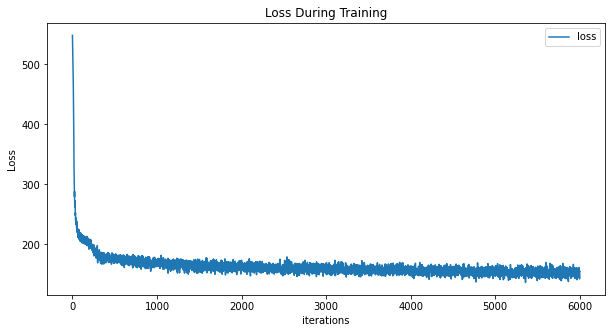

In [18]:
plt.figure(figsize=(10,5))
plt.title("Loss During Training")
plt.plot(loss_check, label="loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

torch.Size([8, 28, 28])
(8, 28, 28)


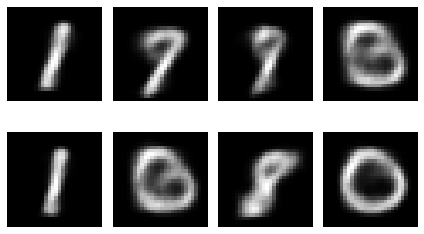

In [19]:
# ノイズの作成数
batch_size=8
# デコーダ入力用に標準正規分布に従う10次元のノイズを作成
z = torch.randn(batch_size, im, device = device)

# 評価モードへの切替 
model.eval()
# デコーダにノイズzを入力
images = model.decoder(z)
images = images.view(-1, 28, 28)
print(images.shape)
images = images.squeeze().detach().cpu().numpy()
print(images.shape)

for i, image in enumerate(images):
    plt.subplot(2, 4, i+1)
    plt.imshow(image, cmap='binary_r')
    plt.axis('off')
plt.tight_layout()
plt.show()

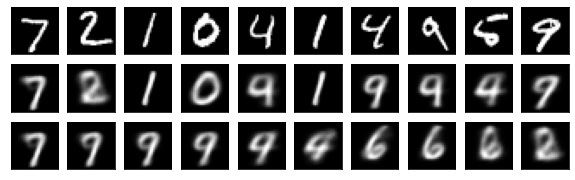

In [20]:
fig = plt.figure(figsize=(10, 3))
model.eval()
for x, t in test_dataloader:
    # 本物画像
    for i, im in enumerate(x.view(-1, 28, 28).detach().numpy()[:10]):
      ax = fig.add_subplot(3, 10, i+1, xticks=[], yticks=[])
      ax.imshow(im, 'gray')
    x = x.to(device)
    # 本物画像から生成画像
    y, z = model(x)
    y = y.view(-1, 28, 28)
    for i, im in enumerate(y.cpu().detach().numpy()[:10]):
      ax = fig.add_subplot(3, 10, i+11, xticks=[], yticks=[])
      ax.imshow(im, 'gray')
    #print(z)
    # 1つ目の画像と2つ目の画像の潜在変数を連続的に変化
    z1to0 = torch.cat([z[1] * (i * 0.1) + z[0] * ((9 - i) * 0.1) for i in range(10)]).reshape(10,2)
    y2 = model.decoder(z1to0).view(-1, 28, 28)
    for i, im in enumerate(y2.cpu().detach().numpy()):
      ax = fig.add_subplot(3, 10, i+21, xticks=[], yticks=[])
      ax.imshow(im, 'gray')
    break

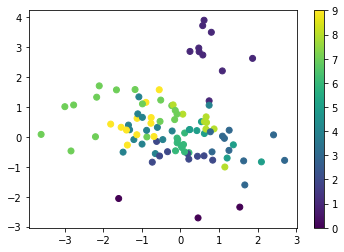

<Figure size 432x432 with 0 Axes>

In [22]:
# display a 2D plot of the digit classes in the latent space

i = 0
x, y = next(iter(train_dataloader))
x = x.to(device)
_, h = model(x)
#print(type(x), x.size(), x)
#print(type(y), y.size(), y[i])
#print(type(h), len(h), h)
sca = plt.scatter(h[:, 0].cpu().detach().numpy(), h[:, 1].cpu().detach().numpy(), c=y.cpu().detach().numpy(), cmap='viridis')
plt.colorbar(sca)
fig = plt.figure(figsize=(6, 6))